In [1]:
# install these libraries if you don't already have them
# !pip install facebook_scraper
# !pip install vaderSentiment
# !pip install openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from collections.abc import Iterable
from facebook_scraper import get_posts 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
import spacy
from spacy.matcher import PhraseMatcher
import statsmodels.api as sm

In [3]:
listposts = []

for post in get_posts('primelands', cookies="/Users/kelumrubasin/Desktop/MSC_DATA_SCIENCE/1_Social_Media_Analytics/Assignment_CIS7029/facebook_data/facebook.com_cookies.txt",
                      pages=25,
                      options={'comments': True}):
    listposts.append(post)
    
print('Number of posts: {}'.format(len(listposts)))   

JSONDecodeError: Extra data: line 1 column 184858 (char 184857)

In [4]:
columns = ['post_id', 
           'time',  
           'text', 
           'likes',
           'comments', 
           'shares', 
           'comments_full']

df_posts = pd.DataFrame(listposts)[columns]

In [5]:
analyzer = SentimentIntensityAnalyzer()

list_comments = []
for index, row in df_posts.iterrows():
    post_id = row['post_id']
    if isinstance(row['comments_full'], Iterable):
        for comment in row['comments_full']:
            dict_temp = {}
            dict_temp['post_id'] = post_id
            dict_temp['comment'] = comment['comment_text']
            dict_temp['sentiment'] = analyzer.polarity_scores(
                comment['comment_text'])['compound']
            list_comments.append(dict_temp)        

df_comments = pd.DataFrame(list_comments)

In [6]:
posts_sentiment = df_comments.groupby('post_id').mean()

df_posts = df_posts.join(posts_sentiment, on=['post_id'])

df_posts.drop(columns=['comments_full'], inplace=True)
df_posts.fillna(0.0, inplace=True)

with pd.ExcelWriter('../primelands.xlsx') as writer:
    df_posts.to_excel(writer, sheet_name='posts_data', index_label='ID')
    df_comments.to_excel(writer, sheet_name='posts_comments', index_label='ID')
    

In [7]:
# Load data from exisiting files to save time
df_posts = pd.read_excel('../primelands.xlsx', sheet_name='posts_data')
df_comments = pd.read_excel('../primelands.xlsx', sheet_name='posts_comments')

In [8]:
# print out dataframe for posts 
df_posts.head()

,ID,post_id,time,text,likes,comments,shares,sentiment
0,0,10160184885147290,2022-07-22 13:36:16,අනුරාධපුර - පුත්තලම පාරට මුහුණලා අගනා නේවාසික ...,52,1,1,0.0000
1,1,10160184882127290,2022-07-22 13:33:03,සුන්දර වෙල්යායකට මුහුණලා අනුරාධපුරෙන් අගනා බිම...,5,1,0,0.0000
2,2,10160184880962290,2022-07-22 13:31:30,දඹුල්ල මහ නගරසභා සීමාවෙන් වටිනා බිම් කොටස්\n👉 ...,4,1,0,0.0772
3,3,10160184877312290,2022-07-22 13:27:39,මුලු ඉඩමම ලක්ෂ 15කට නාරම්මල හොඳම තැනකින්!!!\n📲...,3,1,0,0.0000
4,4,10160183726687290,2022-07-21 19:49:52,අහංගම - ඉමදූව බස් පාරට මුහුණලා අගනා බිම් කොටස්...,2,0,7,0.0000


In [9]:
# print out dataframe for comments 
df_comments.head()

,ID,post_id,comment,sentiment
0,0,10160184880962290,Details pls,0.0772
1,1,10160183721282290,👍👍,0.0000
2,2,10160183713482290,How much one purch,0.0000
3,3,10160183713482290,👍👍,0.0000
4,4,10160183688187290,Price plz,0.0772


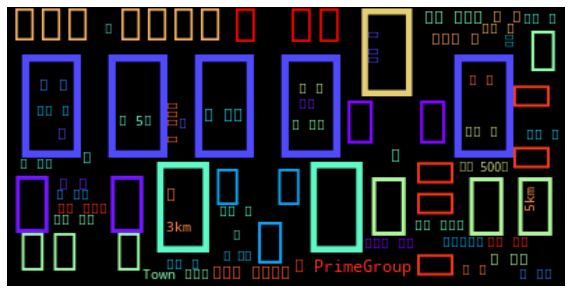

In [10]:
# merge all texts in posts
post_text = ' '.join(df_posts['text'])
post_text = post_text.replace('\n', '') # remove blank lines characters

# update stopwords
stopwords = set(STOPWORDS)
stopwords.update(['https', 'gov', 'au', 'nsw', 's', 're'])

# Generate a word cloud image
wordcloud = WordCloud(random_state=1, 
                      collocations=True, 
                      stopwords=stopwords,
                      max_words=60,
                      background_color='black',
                      colormap ='rainbow',
                      contour_color='steelblue').generate(post_text)

# Function to display word cloud img via matplotlib
def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

# plot world cloud    
plot_cloud(wordcloud)